# Univariate modeling of the time-to-anaphase

Here we use the module ```lifelines``` to perfom our first analysis of the phenomenon using the tools from the survival analysis framework. The analysis shown here has mostly descriptive purposes, since we don't use any features to make predictions regarding the time-to-anaphase, given some early data points measured for a division event.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn

import lifelines

%matplotlib inline
# sns.set_theme()

## Load data

In [2]:
os.chdir("D:\Documents\STAGE\Anaphase")
data = pd.read_csv("Analysis_BF_f0001-1-100.1.csv", sep=";", comment="#", index_col="idx")
data = data[data["time_to_anaphase"] >= 0]

durations = []
for idx in data.index.unique():
    lines = data.loc[idx]
    durations.append(lines[lines["anaphase"]]["time"])
durations = np.array(durations).squeeze(-1)
observed = np.ones(durations.shape, dtype=np.uint8)
survival_data = pd.DataFrame({"idx": data.index.unique(), "duration": durations, "observed": observed}).set_index("idx")

survival_data.head()

,duration,observed
idx,,
0,36,1
1,42,1
2,54,1
3,36,1
4,42,1


## 1. Kaplan-Meier estimate of the survival function

Here we perform a non-parametric estimation of the survival function

$$ S(t) = \mathbb{P}(T > t)$$ 

using the Kaplan-Meier estimate

$$ \hat{S}(t) = \prod_{t_i < t} \frac{n_i - d_i}{n_i} $$

where $n_i$ is the number of cells that didn't divide just before time $t$ and $d_i$ the number of divisions that occured at time $t$.

Text(0.5, 384.16, 'time (min)')

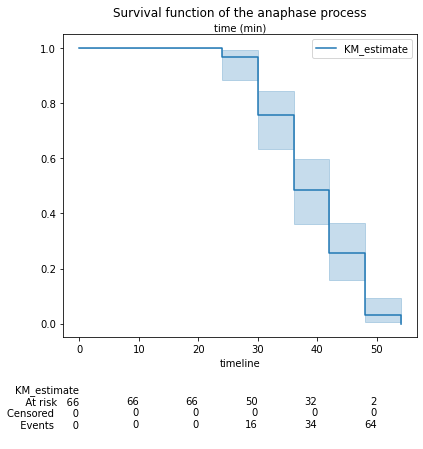

In [4]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter().fit(survival_data["duration"], event_observed=survival_data["observed"])

fig, ax = plt.subplots(1, 1, figsize=(6, 6)) 
kmf.plot_survival_function(ax=ax, at_risk_counts=True)
plt.title("Survival function of the anaphase process")
plt.ylabel(r"$\hat{S}(t) = P(T > t)$")
plt.xlabel("time (min)")

The y-axis represents the probability that a cell has not yet divided at time $t$. The confidence intervals are computed by ```lifelines``` using the exponential Greenwood confidence interval.

In [30]:
print(f"Median survival time : {kmf.median_survival_time_} min.")

Median survival time : 36.0 min.


## 2. Cumulative hazard rates using Nelson-Aalen estimators

Here we estimate the cumulative hazard function

$$H(t) = \int_0^t{\lambda(z) dz} $$

with the non-parametric Nelson-Aalen estimator 

$$ \hat{H}(t) = \sum_{t_i \leq t}{\frac{d_i}{n_i}} $$

where $d_i$ is the number of anaphases that occur at time $t_i$ and $n_i$ is the number of susceptible cells (which haven't divided yet).

          NA_estimate
timeline             
0.0          0.000000
24.0         0.030536
30.0         0.275222
36.0         0.715932
42.0         1.334875


Text(0.5, 0, 'time (min)')

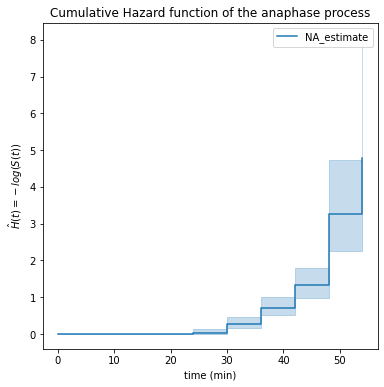

In [6]:
from lifelines import NelsonAalenFitter

naf = NelsonAalenFitter()
naf.fit(survival_data["duration"], event_observed=survival_data["observed"])

print(naf.cumulative_hazard_.head())

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
naf.plot_cumulative_hazard()
plt.title("Cumulative Hazard function of the anaphase process")
plt.ylabel(r"$\hat{H}(t) = - log( S(t) )$")
plt.xlabel("time (min)")

## 3. Cumulative hazard rates the Weibull parametric estimator

Here we estimate the cumulative hazard function with the parametric Weibyll model 

$$ H(t) = (\frac{t}{\lambda})^\rho, \; \lambda > 0, \; \rho > 0 $$

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 66 total observations, 0 right-censored observations>
   number of observations = 66
number of events observed = 66
           log-likelihood = -225.45
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%     z      p   -log2(p)
lambda_  42.05       0.91            40.26            43.84 44.95 <0.005        inf
rho_      5.99       0.57             4.86             7.12  8.69 <0.005      57.88
---
AIC = 454.89

Text(0.5, 0, 'time (min)')

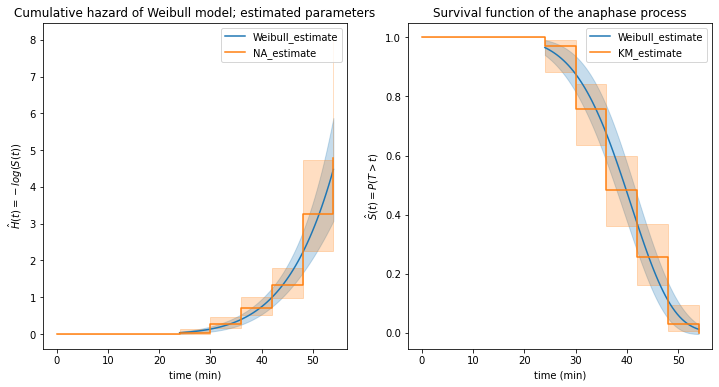

In [12]:
from lifelines import WeibullFitter

wf = WeibullFitter().fit(survival_data["duration"], event_observed=survival_data["observed"])

wf.print_summary()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# cumulative hazard
wf.plot_cumulative_hazard(ax=ax[0])
naf.plot_cumulative_hazard(ax=ax[0])
ax[0].set_ylabel(r"$\hat{H}(t) = - log( S(t) )$")
ax[0].set_xlabel("time (min)")
ax[0].set_title("Cumulative hazard of Weibull model; estimated parameters")

# survival function
wf.plot_survival_function(ax=ax[1])
kmf.plot_survival_function(ax=ax[1])
ax[1].set_title("Survival function of the anaphase process")
ax[1].set_ylabel(r"$\hat{S}(t) = P(T > t)$")
ax[1].set_xlabel("time (min)")